<a href="https://colab.research.google.com/github/coder-2011/MLProjects/blob/main/RainPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


In [ ]:

data_url = "https://raw.githubusercontent.com/BreakoutMentors/Data-Science-and-Machine-Learning/main/datasets/weatherAUS.csv"
data = pd.read_csv(data_url)
data = data.drop(columns=["Cloud9am", "Cloud3pm"])
data = data.drop(columns=["WindGustDir", "Location", "Date", "WindDir9am", "WindDir3pm"])
data = data.dropna()
num_columns = data.select_dtypes(include="number")

def binarize(y):
  if y == "Yes":
    return 1
  return 0

#print(num_columns)
means = num_columns.mean()
std = num_columns.std()
# print(means)
# print(std)
num_columns = (num_columns-means)/std
for col in num_columns.columns:
  data[col] = num_columns[col]


data["RainToday"] = data['RainToday'].map(binarize)
data["RainTomorrow"] = data["RainTomorrow"].map(binarize)
# data['RainTomorrow'].hist()

def balance(data):
  rainy_days = data.loc[data['RainTomorrow'] == 1]
  dry_days = data.loc[data['RainTomorrow'] == 0]
  dry_days = dry_days.sample(len(rainy_days))
  return pd.concat([dry_days, rainy_days], axis=0).sample(frac=1)

data = balance(data)
#data['RainTomorrow'].hist()
print(data)

         MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
105336 -0.079572 -0.644932 -0.304787     0.604587 -0.119637       2.114409   
83162  -0.547425 -0.316817 -0.304787     0.227947 -0.887699       0.551290   
99873   0.403876  0.410743 -0.304787    -0.310110 -1.920609      -0.267486   
100219  0.060784 -0.644932 -0.216111     0.873615  0.065757       0.030251   
122389  0.013999 -0.345349 -0.304787    -1.224806 -0.834729      -0.118618   
...          ...       ...       ...          ...       ...            ...   
101076 -0.594210 -0.915984 -0.304787    -0.848167 -1.099578       0.700159   
34834   0.887325  0.681794 -0.304787     2.164951  0.807334       2.114409   
34841  -0.079572  0.054096 -0.304787     0.066530 -1.311457       1.518935   
82909  -1.280394 -1.515150  3.153551    -1.117195 -1.576306       3.007619   
73372  -0.937302 -0.359615 -0.304787    -0.363916  0.357091       0.179119   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  P

In [ ]:

x_data = torch.tensor(data.drop(columns="RainTomorrow").values, dtype=torch.float) # TV numbers
y_data = torch.tensor(data["RainTomorrow"].values, dtype=torch.float) # Sales
y_data = y_data.reshape(-1, 1)
print(x_data.shape, y_data.shape)

torch.Size([28860, 15]) torch.Size([28860, 1])


In [ ]:
class LogisticRegression(torch.nn.Module):
  def __init__(self):
      super().__init__()

      self.linear = torch.nn.Linear(15, 1)
      self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x):
      linearResult = self.linear(x)
      # print(x)
      # print(linearResult)
      # print(self.sigmoid(linearResult))
      return self.sigmoid(linearResult)

model = LogisticRegression()
model(x_data[100:105])

tensor([[0.6295],
        [0.5594],
        [0.5053],
        [0.4920],
        [0.5517]], grad_fn=<SigmoidBackward0>)

In [ ]:
# def lossfn(y_predictions, y_true):

#   return (y_predictions-y_true).pow(2).sum()

lossfn = torch.nn.BCELoss()

result = model(x_data[:5])
print(x_data[:5])
print(result)
print(y_data[:5])

def getPredictions(prob):
  bools = prob>0.5
  return bools.float()


print(getPredictions(result))
print(getPredictions(result).eq(y_data[:5]).sum())

tensor([[-7.9572e-02, -6.4493e-01, -3.0479e-01,  6.0459e-01, -1.1964e-01,
          2.1144e+00,  4.0713e+00,  1.8270e+00,  5.3910e-01, -7.7482e-04,
         -2.1525e+00, -1.7126e+00, -5.4720e-01, -5.4145e-01,  0.0000e+00],
        [-5.4742e-01, -3.1682e-01, -3.0479e-01,  2.2795e-01, -8.8770e-01,
          5.5129e-01, -9.3577e-01,  1.0027e+00,  1.6509e+00,  3.4412e-01,
         -2.2272e-01, -1.8298e-01, -5.0165e-01, -2.2125e-01,  0.0000e+00],
        [ 4.0388e-01,  4.1074e-01, -3.0479e-01, -3.1011e-01, -1.9206e+00,
         -2.6749e-01,  2.2866e-01,  6.0510e-02,  5.3910e-01,  1.5759e+00,
         -1.2302e+00, -1.4410e+00,  5.4600e-01, -9.0257e-02,  0.0000e+00],
        [ 6.0784e-02, -6.4493e-01, -2.1611e-01,  8.7361e-01,  6.5757e-02,
          3.0251e-02, -2.3711e-01,  1.2382e+00,  2.7440e-01, -7.7482e-04,
         -1.1876e+00, -8.1197e-01, -2.1317e-01, -5.7056e-01,  0.0000e+00],
        [ 1.3999e-02, -3.4535e-01, -3.0479e-01, -1.2248e+00, -8.3473e-01,
         -1.1862e-01, -7.0288e-01,

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch: 0, current loss: 0.711769163608551 accuracy: 49.41788101196289%
epoch: 100, current loss: 0.5818712711334229 accuracy: 73.07345581054688%
epoch: 200, current loss: 0.5239724516868591 accuracy: 76.76715087890625%
epoch: 300, current loss: 0.4946465790271759 accuracy: 77.6957778930664%
epoch: 400, current loss: 0.4778488576412201 accuracy: 78.26749420166016%
epoch: 500, current loss: 0.4672994315624237 accuracy: 78.51004791259766%
epoch: 600, current loss: 0.4602181017398834 accuracy: 78.83576202392578%
epoch: 700, current loss: 0.45520541071891785 accuracy: 78.99861145019531%
epoch: 800, current loss: 0.4514903724193573 accuracy: 79.14067840576172%
epoch: 900, current loss: 0.44862422347068787 accuracy: 79.23770141601562%
epoch: 1000, current loss: 0.446336030960083 accuracy: 79.33125305175781%
epoch: 1100, current loss: 0.4444570541381836 accuracy: 79.40402221679688%
epoch: 1200, current loss: 0.4428792893886566 accuracy: 79.42134857177734%
epoch: 1300, current loss: 0.441531240

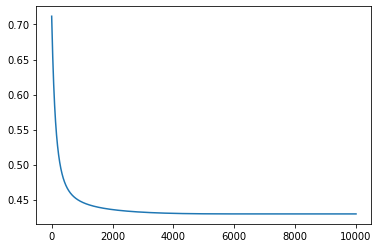

In [ ]:
loss_history = []

for i in range(10000):

  optimizer.zero_grad()

  predicted_y = model(x_data)

  current_loss = lossfn(predicted_y, y_data)

  current_loss.backward()

  optimizer.step()

  accuracy = getPredictions(predicted_y).eq(y_data).sum()/y_data.shape[0]*100

  loss_history.append(current_loss.item())
  if i % 100 == 0:
    print(f'epoch: {i}, current loss: {current_loss.item()} accuracy: {accuracy}%')

plt.plot(loss_history)

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [0.]])
[[11757  2673]
 [ 3115 11315]]


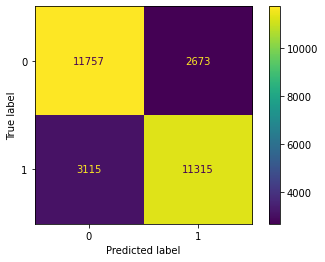

In [ ]:
probability_y = model(x_data)
binary_y = getPredictions(probability_y)
cm = metrics.confusion_matrix(y_data, binary_y)
print(binary_y)
print(cm)
cmd = metrics.ConfusionMatrixDisplay(cm)
cmd.plot()